<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/MID_Landsat_preprocesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preprocesamiento de Landsat 8 para ANN
* MID - Mérida (sur, Merida)
* Versión con la estandarizaciíón de datos con StandardScaler
* Referencia tres clases (no-urbano, urbano, agua)

Preparar el entorno

In [1]:
import ee
import geemap
import random
import math, glob, time
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

random.seed(2)

Conección con GEE

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-viacheslavs')

Coneccion con Google Drive para almacenar archivos

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


Definición de variables

In [5]:
prefijo = 'MID'

fecha_inicio_2020 = '2020-02-01'
fecha_final_2020 = '2020-05-30'
fecha_inicio_2015 = '2015-01-01'
fecha_final_2015 = '2015-05-30'
fecha_inicio_2014 = '2014-01-01'
fecha_final_2014 = '2014-05-30'
fecha_inicio_2011 = '2011-02-01'
fecha_final_2011 = '2011-05-30'
fecha_inicio_2010 = '2010-01-01'
fecha_final_2010 = '2010-05-30'
fecha_inicio_2000 = '2000-02-01'
fecha_final_2000 = '2000-05-30'


punto_interes = ee.Geometry.Point([-89.6237, 20.9674]) # punto ciudad
#punto_interes = ee.Geometry.Point([-89.645748, 20.852812])  # Punto sur
print(punto_interes.getInfo())

limites_utm = [185309, 247956, 2300970, 2361733]
pixel = 30
#max_tile = 250000
max_tile = 250000
utm13 = ee.Projection('EPSG:32616')

bands_L8 = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
bands_L8_mean = ['SR_B2_mean','SR_B3_mean','SR_B4_mean','SR_B5_mean','SR_B6_mean','SR_B7_mean']
bands_L5 = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7']
bands_L5_mean = ['SR_B1_mean','SR_B2_mean','SR_B3_mean','SR_B4_mean','SR_B5_mean','SR_B7_mean']
bands_B = ['settlement']

{'type': 'Point', 'coordinates': [-89.6237, 20.9674]}


In [43]:
#def bitwiseExtract(input, fromBit, toBit):
#  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
#  mask = ee.Number(1).leftShift(maskSize).subtract(1)
#  return input.rightShift(fromBit).bitwiseAnd(mask)

#def cloudmaskerL8(input_image):
#  qa = input_image.select(['QA_PIXEL'])
#  cloudQualityMask = bitwiseExtract(qa, 3, 3)
#  shadowQualityMask = bitwiseExtract(qa, 10, 11)
#  #cloud_mask = qa.bitwiseAnd(cloudQualityMask).lt(1)
#  cloud_mask = qa.bitwiseAnd(cloudQualityMask).eq(0)
#  shadow_mask = qa.bitwiseAnd(shadowQualityMask).lt(1)
#  imageMasked = input_image.updateMask(cloud_mask).updateMask(shadow_mask)
#  return imageMasked

## funcion para eliminar nubes y sombras
def maskClouds(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow_bit_mask = (1 << 3)
    cloud_bit_mask = (1 << 4)
    cloud_mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0).And(qa.bitwiseAnd(cloud_bit_mask).eq(0))
    return image.updateMask(cloud_mask)

def maskCloudsL5(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow_bit_mask = (1 << 3)
    cloud_bit_mask = (1 << 4)
    cloud_mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0).And(qa.bitwiseAnd(cloud_bit_mask).eq(0))
    return image.updateMask(cloud_mask)

Lectura de datos Lanstas 8

In [8]:
L8_collection_2015 = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                      .filterBounds(punto_interes)
                      .filter(ee.Filter.calendarRange(2,5,'month'))
                      .filter(ee.Filter.calendarRange(2015, 2016, 'year'))
                      #.filterDate(fecha_inicio_2015, fecha_final_2015)
                      .filter(ee.Filter.lessThan('CLOUD_COVER', 5)))
print('Capas de datos filtrados 2015:', L8_collection_2015.size().getInfo())

# Cargar imagen de la colección (Landsat 8).
## requerimos contar con imagen 2015 original para obtener datos de proyeccion
L8_image_2015 = L8_collection_2015.first()
image_meta_2015 = L8_image_2015.getInfo()
imagename_2015 = image_meta_2015.get('properties',{}).get('LANDSAT_PRODUCT_ID')
print('Imagen 2015 elegido:', imagename_2015)

## generar el mosaico de 2015
L8_image_2015_mosaic = L8_collection_2015.map(maskClouds).reduce(ee.Reducer.mean())
#L8_collection_2015_masked = L8_collection_2015.map(maskClouds)
#L8_image_2015_mosaic = L8_collection_2015_masked.mosaic()

# filtrado de datos Landsat potencialemtne adecuados
L8_collection_2020 = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                      .filterBounds(punto_interes)
                      .filterDate(fecha_inicio_2020, fecha_final_2020)
                      .filter(ee.Filter.lessThan('CLOUD_COVER', 1)))
print('Capas de datos filtrados 2020:', L8_collection_2020.size().getInfo())

# Cargar imagen de la colección (Landsat 8).
#L8_image_2020 = L8_collection_2020.first()
L8_image_2020_mosaic = L8_collection_2020.map(maskClouds).reduce(ee.Reducer.mean())
#image_meta_2020 = L8_image_2020.getInfo()
#imagename_2020 = image_meta_2020.get('properties',{}).get('LANDSAT_PRODUCT_ID')
#print('Imagen 2020 elegido:', imagename_2020)

L8_collection_2014 = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                      .filterBounds(punto_interes)
                      .filter(ee.Filter.calendarRange(2,5,'month'))
                      .filter(ee.Filter.calendarRange(2014, 2015, 'year'))
                      #.filterDate(fecha_inicio_2014, fecha_final_2014)
                      .filter(ee.Filter.lessThan('CLOUD_COVER', 5)))
print('Capas de datos filtrados 2014:', L8_collection_2014.size().getInfo())

# Cargar imagen de la colección (Landsat 8).
L8_image_2014_mosaic = L8_collection_2014.map(maskClouds).reduce(ee.Reducer.mean())
#image_meta_2014 = L8_image_2014.getInfo()
#imagename_2014 = image_meta_2014.get('properties',{}).get('LANDSAT_PRODUCT_ID')
#print('Imagen 2014 elegido:', imagename_2014)

## Despues de mosaic todos datos no estan en la proyeccion correcta, pero estan en "default projection"
projection = L8_image_2015.projection().getInfo();
print(projection)
print(projection.get('crs'))
print(projection.get('transform'))

L8_image_2020_re = L8_image_2020_mosaic.reproject(projection.get('crs'), projection.get('transform'), None)
L8_image_2015_re = L8_image_2015_mosaic.reproject(projection.get('crs'), projection.get('transform'), None)
L8_image_2014_re = L8_image_2014_mosaic.reproject(projection.get('crs'), projection.get('transform'), None)

Capas de datos filtrados 2015: 5
Imagen 2015 elegido: LC08_L2SP_020045_20160212_20200907_02_T1
Capas de datos filtrados 2020: 3
Capas de datos filtrados 2014: 4
{'type': 'Projection', 'crs': 'EPSG:32616', 'transform': [30, 0, 160485, 0, -30, 2515215]}
EPSG:32616
[30, 0, 160485, 0, -30, 2515215]


Lectura de datos Landsat 5

In [59]:
# filtrado de datos Landsat potencialemtne adecuados
L5_collection_2011 = (ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
                      .filterBounds(punto_interes)
                      .filter(ee.Filter.calendarRange(1,3,'month'))
                      .filter(ee.Filter.calendarRange(2010, 2012, 'year'))
                      #.filterDate(fecha_inicio_2011, fecha_final_2011)
                      .filter(ee.Filter.lessThan('CLOUD_COVER', 10))
                      .sort("system:time_start"))
print('Capas de datos filtrados 2011:', L5_collection_2011.size().getInfo())

L5_image_2011_mosaic = L5_collection_2011.map(maskCloudsL5).reduce(ee.Reducer.mean())
#L5_image_2011 = L5_collection_2011.first()
#image_meta_2011 = L5_image_2011.getInfo()
#imagename_2011 = image_meta_2011.get('properties',{}).get('LANDSAT_PRODUCT_ID')
#print('Imagen 2011 elegido:', imagename_2011)

# filtrado de datos Landsat potencialemtne adecuados
L5_collection_2010 = (ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
                      .filterBounds(punto_interes)
                      .filter(ee.Filter.calendarRange(1,3,'month'))
                      .filter(ee.Filter.calendarRange(2009, 2011 , 'year'))
                      #.filterDate(fecha_inicio_2010, fecha_final_2010)
                      .filter(ee.Filter.lessThan('CLOUD_COVER', 10)))
print('Capas de datos filtrados 2010:', L5_collection_2010.size().getInfo())

L5_image_2010_mosaic = L5_collection_2010.map(maskCloudsL5).reduce(ee.Reducer.mean())
#L5_image_2010_mosaic = L5_collection_2010.reduce(ee.Reducer.mean())
#L5_image_2010 = L5_collection_2010.first()
#image_meta_2010 = L5_image_2010.getInfo()
#imagename_2010 = image_meta_2010.get('properties',{}).get('LANDSAT_PRODUCT_ID')
#print('Imagen 2010 elegido:', imagename_2010)

# filtrado de datos Landsat potencialemtne adecuados
L5_collection_2000 = (ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
                      .filterBounds(punto_interes)
                      .filter(ee.Filter.calendarRange(1,5,'month'))
                      .filter(ee.Filter.calendarRange(1999, 2002 , 'year'))
                      #.filterDate(fecha_inicio_2000, fecha_final_2000)
                      .filter(ee.Filter.lessThan('CLOUD_COVER', 0.5)))
print('Capas de datos filtrados 2000:', L5_collection_2000.size().getInfo())

#L5_image_2000_mosaic = L5_collection_2000.map(maskCloudsL5).reduce(ee.Reducer.mean())
L5_image_2000_mosaic = L5_collection_2000.reduce(ee.Reducer.mean())
#L5_image_2000 = L5_collection_2000.first()
#image_meta_2000 = L5_image_2000.getInfo()
#imagename_2000 = image_meta_2000.get('properties',{}).get('LANDSAT_PRODUCT_ID')
#print('Imagen 2000 elegido:', imagename_2000)

# Rellenar huecos
L5_image_2011_mosaic = ee.ImageCollection([L5_image_2000_mosaic, L5_image_2010_mosaic]).mosaic();
L5_image_2010_mosaic = ee.ImageCollection([L5_image_2000_mosaic, L5_image_2010_mosaic]).mosaic();

L5_image_2011_re = L5_image_2011_mosaic.reproject(projection.get('crs'), projection.get('transform'), None)
L5_image_2010_re = L5_image_2010_mosaic.reproject(projection.get('crs'), projection.get('transform'), None)
L5_image_2000_re = L5_image_2000_mosaic.reproject(projection.get('crs'), projection.get('transform'), None)

Capas de datos filtrados 2011: 4
Capas de datos filtrados 2010: 4
Capas de datos filtrados 2000: 6


Cargar capas de datos de referencia

In [15]:
# Load builtup 2015 (res 100 m)
ghs_built_image = ee.Image('JRC/GHSL/P2023A/GHS_BUILT_S/2015')
built_2015_lr = ghs_built_image.select('built_surface')

# Load builtup 2015 (res 10 m) y reclasificar a 0 y 1
built_2015_hr = ee.Image('DLR/WSF/WSF2015/v1')
built_2015_hr = built_2015_hr.where(built_2015_hr.eq(255), 1)

# Load water mask (res 30)
elev_dataset = ee.ImageCollection('COPERNICUS/DEM/GLO30').filterBounds(L8_image_2015.geometry())
print('Segmentos WBM filtrados:', elev_dataset.size().getInfo())
MDE_Copernicus_proj = elev_dataset.first().projection()
water_mosaico = elev_dataset.select('WBM').mosaic()
water_mosaico = water_mosaico.setDefaultProjection(MDE_Copernicus_proj)
water_bin = water_mosaico.gt(0)

# blackBackground = ee.Image(0);

Segmentos WBM filtrados: 7


Reproyección y homogenización de capas

In [16]:
## Datos deben quedar convertidos a proyección identica a la de Landsat 8, con mismo tamaño y resolución.

## Reproject label layers to L8 projection
built_2015_hr_reprojected = built_2015_hr.reproject(projection.get('crs'), projection.get('transform'))
water_bin_reprojected = water_bin.reproject(projection.get('crs'), projection.get('transform'))

## Combinación de capas de builtup y agua en una capa categorica de tres clases (0 - no-urbano, 1 - agua, 2 - urbano)
built_2015_agua_hr_reprojected = built_2015_hr_reprojected.unmask(0)
built_2015_agua_hr_reprojected = (built_2015_agua_hr_reprojected.where(built_2015_agua_hr_reprojected.eq(1), 2))
built_2015_agua_hr_reprojected = (built_2015_agua_hr_reprojected.where(water_bin_reprojected.eq(1), 1))

Visualizar capas de datos (con uso de geemap).

Nota: no siempre funciona de forma correcta

In [61]:
Map = geemap.Map()
# Center the map and display the image.
Map.centerObject(punto_interes, 10)

# Parametros de visualizacion para Landsat 8
vizParams_L8 = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
   'min': 5000,
   'max': 15000
  #'gamma': [0.95, 1.1, 1]
}

vizParams_L8_mean = {
  'bands': ['SR_B5_mean', 'SR_B4_mean', 'SR_B3_mean'],
   'min': 5000,
   'max': 15000
  #'gamma': [0.95, 1.1, 1]
}

vizParams_L5_mean = {
  'bands': ['SR_B4_mean', 'SR_B3_mean', 'SR_B2_mean'],
   'min': 1000,
   'max': 15000
  #'gamma': [0.95, 1.1, 1]
}

# Parametros de visualizacion para Builtup LR
vizBuiltup_LR = {
   'min': 0,
   'max': 1,
  'palette': ['white','black']
}
# Parametros de visualizacion para Builtup HR
vizBuiltup_HR = {
  min: 0,
  max: 255,
  'palette': ['white','black']
}

vizWater = {
   'min': 0,
   'max': 3,
  'palette': ['white', 'blue', 'darkblue']
}
vizWaterBin = {
   'min': 0,
   'max': 1,
  'palette': ['white', 'blue']
}

vizBuiltupAgua = {
   'min': 0,
   'max': 2,
  'palette': ['white', 'blue', 'black']
}
# Agregar capas
Map.addLayer(L8_image_2020_re, vizParams_L8_mean, '2020 falso color', False, 1)
Map.addLayer(L8_image_2015_re, vizParams_L8_mean, '2015 falso color', True, 1)
Map.addLayer(L8_image_2014_re, vizParams_L8_mean, '2014 falso color', False, 1)
Map.addLayer(L5_image_2011_re, vizParams_L5_mean, '2011 falso color', False, 1)
Map.addLayer(L5_image_2010_re, vizParams_L5_mean, '2010 falso color', False, 1)
Map.addLayer(L5_image_2000_re, vizParams_L5_mean, '2000 falso color', False, 1)
Map.addLayer(built_2015_lr, vizBuiltup_LR, 'Builtup 2015 100m', False, 0.5)
Map.addLayer(built_2015_hr, vizBuiltup_HR, 'Builtup 2015 10m', False, 0.5)
#Map.addLayer(water_mosaico, vizWater, 'Agua', False, 0.5)
Map.addLayer(water_bin, vizWaterBin, 'Agua mask', False, 0.5)
Map.addLayer(built_2015_agua_hr_reprojected, vizBuiltupAgua, 'Builtup 2015 y agua', False, 0.5)

# Presentar mapa
Map


Map(center=[20.9674, -89.6237], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

Definición de rectangula segmentado para canversión de GEE a numpy

In [62]:
def segmentation(limits, pixel_size, max_tile_size, proj):
  alto = math.ceil((limits[3] - limits[2]) / pixel_size)
  print('Alto del segmento (pixeles)', alto)
  ancho = math.ceil(max_tile_size / alto)
  print('Ancho del segmento (pixeles)', ancho)
  incremento = ancho * pixel_size
  print('Ancho del segmento (unidades de proyeccion)', incremento)
  seq = list(np.arange(limits[0], limits[1], incremento))
  print('Secuencia de marcas de longitud')
  print(seq)
  segments = []
  for i in range(len(seq)-1):
    #print(seq[i], seq[i+1])
    segment = ee.Geometry.Rectangle([int(seq[i]), limites_utm[2], int(seq[i+1]), limites_utm[3]], proj, True, False)
    #print(segment)
    segments.append(segment)
  return segments

segment_list = segmentation(limites_utm, pixel, max_tile, utm13)

Map1 = geemap.Map()
bbox = ee.Geometry.Rectangle([limites_utm[0], limites_utm[2], limites_utm[1], limites_utm[3]], utm13, True, False)
Map1.centerObject(punto_interes, 10)
Map1.addLayer(bbox, {}, 'Area de estudio')
Map1

Alto del segmento (pixeles) 2026
Ancho del segmento (pixeles) 124
Ancho del segmento (unidades de proyeccion) 3720
Secuencia de marcas de longitud
[185309, 189029, 192749, 196469, 200189, 203909, 207629, 211349, 215069, 218789, 222509, 226229, 229949, 233669, 237389, 241109, 244829]


Map(center=[20.9674, -89.6237], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

Funciones para conversión de datos en numpy array para el analisis

In [63]:
def tile_to_numpy(image, rectangle, bands):
  ## extraccion de bandas en un region rectangular
  image_tile = image.sampleRectangle(region=rectangle,defaultValue=0)
  first_band = image_tile.get(bands[0])
  band_array_np = np.array(first_band.getInfo())
  band_array_np = np.expand_dims(band_array_np, 2)
  for b in bands[1:]:
    b_arr = image_tile.get(b)
    b_arr_np = np.array(b_arr.getInfo())
    b_arr_np = np.expand_dims(b_arr_np, 2)
    #print(b_arr_np.shape)
    #print(band_array_np.shape)
    band_array_np = np.concatenate((band_array_np, b_arr_np), 2)
  return band_array_np

def merge_feature_array(image, segments, bands):
  ## combinaccion de segmentos
  array_feature = tile_to_numpy(image, segments[0], bands)
  print("New feature array", array_feature.shape)
  for segment in segments[1:]:
    feature_segment = tile_to_numpy(image, segment, bands)
    print("Feature segment", feature_segment.shape)
    array_feature = np.concatenate((array_feature, feature_segment), 1)
  print("Full new feature array", array_feature.shape)
  return array_feature


Preparar datos de entrenamiento en zona de estudio para el año 2015

---



New feature array (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Full new feature array (2026, 2000, 6)


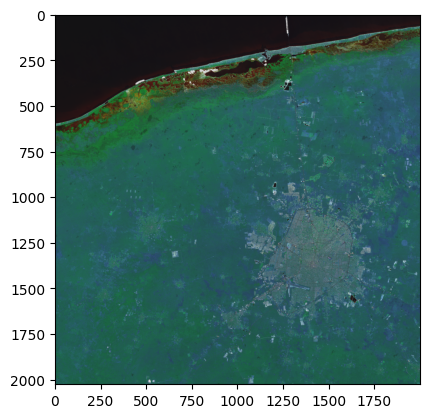

In [ ]:
array_feature_2015 = merge_feature_array(L8_image_2015_re, segment_list, bands_L8_mean)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (255*((array_feature_2015 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

Preparar datos de imagen 2020 para predicción

New feature array (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Full new feature array (2026, 2000, 6)


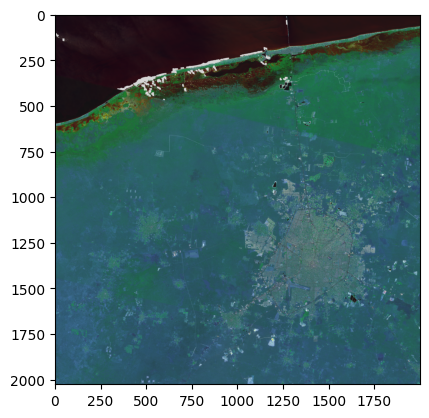

In [ ]:

array_feature_2020 = merge_feature_array(L8_image_2020_re, segment_list, bands_L8_mean)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (255*((array_feature_2020 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

Preparar datos de imagen 2014 para predicción

New feature array (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Full new feature array (2026, 2000, 6)


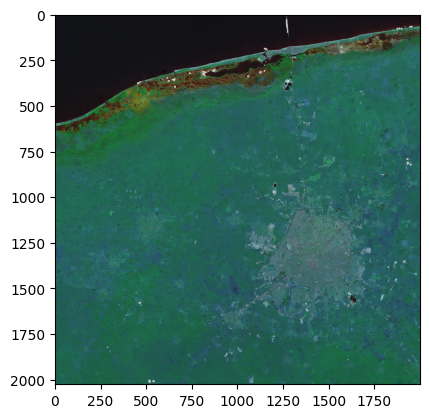

In [ ]:
array_feature_2014 = merge_feature_array(L8_image_2014_re, segment_list, bands_L8_mean)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (255*((array_feature_2014 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

In [ ]:
## Images L8
np.save('/content/drive/MyDrive/Colab Data/MID_2020_feature_L8_6b.npy', array_feature_2020)
np.save('/content/drive/MyDrive/Colab Data/MID_2015_feature_L8_6b.npy', array_feature_2015)
np.save('/content/drive/MyDrive/Colab Data/MID_2014_feature_L8_6b.npy', array_feature_2014)

Preparar datos de imagen 2011 para predicción

New feature array (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Full new feature array (2026, 2000, 6)


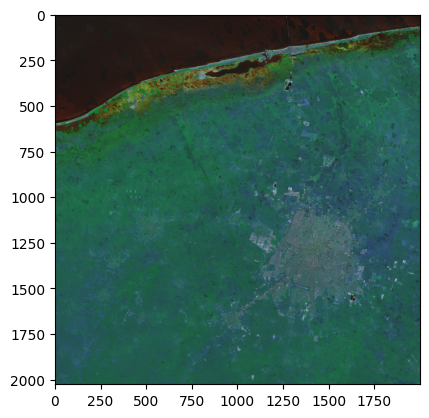

In [64]:
array_feature_2011 = merge_feature_array(L5_image_2011_re, segment_list, bands_L5_mean)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (255*((array_feature_2011 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

Preparar datos de imagen 2010 para predicción

New feature array (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Full new feature array (2026, 2000, 6)


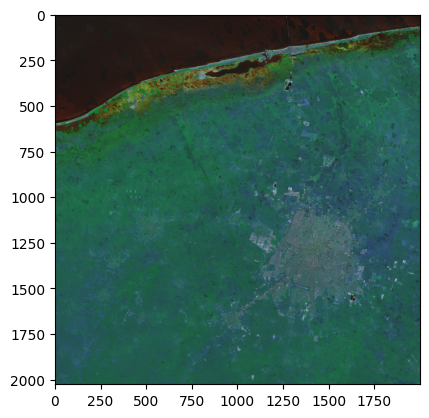

In [65]:
array_feature_2010 = merge_feature_array(L5_image_2010_re, segment_list, bands_L5_mean)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (255*((array_feature_2010 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

Preparar datos 2000 para predicción

New feature array (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Feature segment (2026, 125, 6)
Full new feature array (2026, 2000, 6)


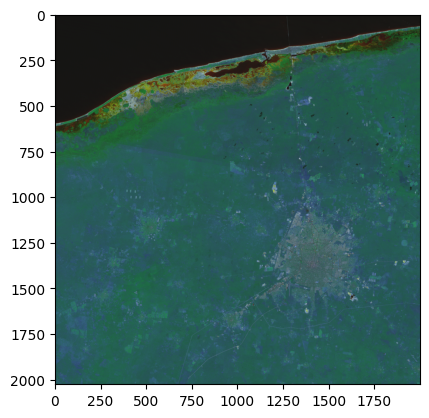

In [66]:
array_feature_2000 = merge_feature_array(L5_image_2000_re, segment_list, bands_L5_mean)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (255*((array_feature_2000 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

In [67]:
np.save('/content/drive/MyDrive/Colab Data/MID_2011_feature_L5_6b.npy', array_feature_2011)
np.save('/content/drive/MyDrive/Colab Data/MID_2010_feature_L5_6b.npy', array_feature_2010)
np.save('/content/drive/MyDrive/Colab Data/MID_2000_feature_L5_6b.npy', array_feature_2000)

Capas de etiquetas para entrenamiento de 3 clases y de 2 clases

New feature array (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Full new feature array (2026, 2000, 1)


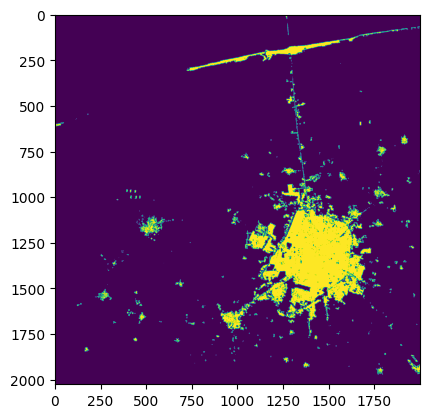

Valores únicos de clases [0 1]
Conteo de pixeles de valores únicos [3743908  308092]


In [68]:
array_target_binary_2015 = merge_feature_array(built_2015_hr_reprojected, segment_list, bands_B)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (array_target_binary_2015).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

unique_values_bin, occurrence_count_bin = np.unique(array_target_binary_2015, return_counts=True)
print('Valores únicos de clases', unique_values_bin)
print('Conteo de pixeles de valores únicos', occurrence_count_bin)

New feature array (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Feature segment (2026, 125, 1)
Full new feature array (2026, 2000, 1)


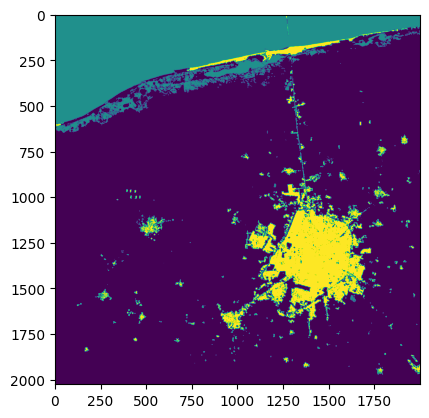

Valores únicos de clases [0 1 2]
Conteo de pixeles de valores únicos [3126623  618214  307163]


In [69]:
array_target_2015 = merge_feature_array(built_2015_agua_hr_reprojected, segment_list, bands_B)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (array_target_2015).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

unique_values, occurrence_count = np.unique(array_target_2015, return_counts=True)
print('Valores únicos de clases', unique_values)
print('Conteo de pixeles de valores únicos', occurrence_count)

Guardar los conjuntos de datos concatenados (numpy array)

In [70]:
## Save the arrays as .npy files

## Targets
np.save('/content/drive/MyDrive/Colab Data/MID_2015_target_2class.npy', array_target_binary_2015)
np.save('/content/drive/MyDrive/Colab Data/MID_2015_target_3class.npy', array_target_2015)